In [1]:
## mount gdrive
import os
from google.colab import drive
drive.mount('/content/drive/')
# Check if a GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Mounted at /content/drive/
Device: cuda


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from skimage.transform import radon
import torchvision
import os
import pickle
import random
import numpy as np
import gzip
import torchvision.datasets as datasets
from torchvision import transforms
transform = torchvision.transforms.Compose([transforms.ToTensor()])

#### some data-loading functionalities
datapath = '/content/drive/My Drive/assistant_prof_jobs_documents/IIT-Kgp ECE job/teaching@IITKgp/cambridge_IA_minor_2025/coursework_codes/practical_codes/mnist_dataset'
full_trainset = datasets.MNIST(root=datapath, train=True, download=True, transform=transform)
full_testset = datasets.MNIST(root=datapath, train=False, download=False, transform=transform)
print('total #train images: {}, #test images: {}'.format(len(full_trainset), len(full_testset)))

#### we will create a small subset of MNIST for both training and testing
random_sampler_train = torch.utils.data.RandomSampler(full_trainset, num_samples=2000)
train_dataloader = torch.utils.data.DataLoader(full_trainset, batch_size=20, sampler=random_sampler_train)

random_sampler_test = torch.utils.data.RandomSampler(full_testset, num_samples=100)
test_dataloader = torch.utils.data.DataLoader(full_testset, batch_size=20, sampler=random_sampler_test)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.63MB/s]

total #train images: 60000, #test images: 10000


In [4]:
### returns the forward operator and the adjoint given a kernel of size p-by-p
import torch.nn as nn
def conv2d_block(kernel, channels, p, device, stride=1):
    """
    Returns nn.Conv2d and nn.ConvTranspose2d modules from 2D kernel, such that
    nn.ConvTranspose2d is the adjoint operator of nn.Conv2d
    Arg:
        kernel: 2D kernel, p x p is the kernel size
        channels: number of image channels
    """
    kernel_size = kernel.shape
    kernel = kernel/kernel.sum()
    kernel = kernel.repeat(channels, 1, 1, 1)
    filter = nn.Conv2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
        padding=p//2
    )
    filter.weight.data = kernel
    filter.weight.requires_grad = False

    filter_adjoint = nn.ConvTranspose2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
        padding=p//2,
    )
    filter_adjoint.weight.data = kernel
    filter_adjoint.weight.requires_grad = False

    return filter.to(device), filter_adjoint.to(device)

# Motion blur operator
p = 7 #kernel_size
kernel_motion_blur = (1/p**2)*torch.ones((p, p)).type(torch.FloatTensor).to(device)
fwd_op, adj_op = conv2d_block(kernel_motion_blur, channels = 1, p = 7, device=device)

In [5]:
### create the networks
class prox_net_dual(nn.Module):
    def __init__(self, n_in_channels=3, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(prox_net_dual, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)


    def forward(self, h, y, z):
        dh = torch.cat((h, y, z), dim=1)
        dh = self.act1(self.conv1(dh))
        dh = self.act2(self.conv2(dh))
        dh = self.conv3(dh)
        return h + dh

class prox_net_primal(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(prox_net_primal, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return x + dx

class LPD(nn.Module):
    def __init__(self, fwd_op, adjoint_op, niter=5, sigma=0.01, tau=0.01):
        super(LPD, self).__init__()

        self.fwd_op = fwd_op
        self.adj_op = adj_op
        self.niter = niter
        self.sigma = nn.Parameter(sigma * torch.ones(1).to(device))
        self.tau = nn.Parameter(tau * torch.ones(1).to(device))
        self.cnn_image_layers = prox_net_primal().to(device)
        self.cnn_data_layers = prox_net_dual().to(device)

    def forward(self, y, x_init):
        x = x_init
        h = torch.zeros_like(y)
        for iteration in range(self.niter):
            h = self.cnn_data_layers(h, y, self.sigma * self.fwd_op(x))
            x = self.cnn_image_layers(x, self.tau * self.adj_op(h))
        return x


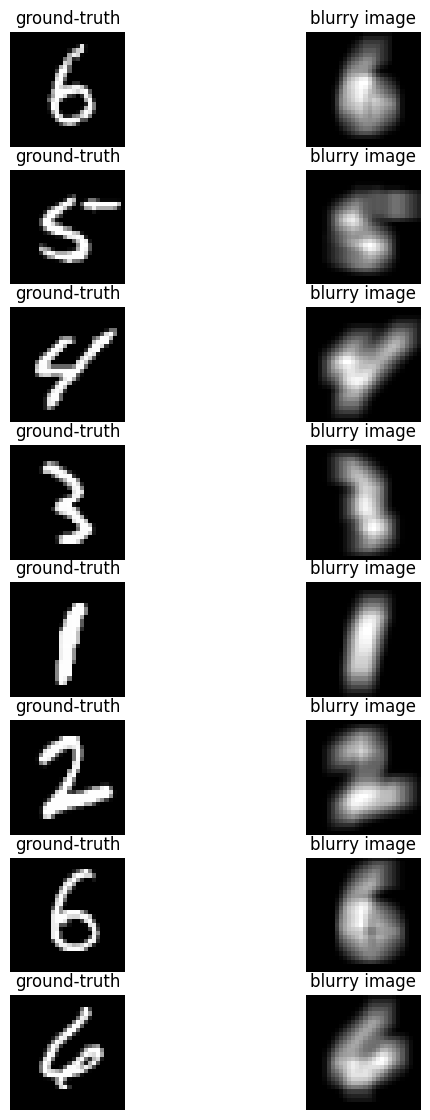

In [6]:
#### Let's visualize some of the training images
import matplotlib.pyplot as plt
for batch_idx, (x_true, _) in enumerate(train_dataloader):
  x_true = x_true.to(device)
  y = fwd_op(x_true)

  num_samples = min(8, y.size(0))  # Limit to 8 samples for visualization
  fig, axes = plt.subplots(num_samples, 2, figsize=(7, 14))
  ### let's see the images
  for i in range(num_samples):


        # Plot sinogram
        axes[i, 0].imshow((x_true[i].cpu().squeeze()), cmap='gray')
        axes[i, 0].set_title('ground-truth')

        # Plot ground truth image
        axes[i, 1].imshow((y[i].cpu().squeeze()), cmap='gray')
        axes[i, 1].set_title('blurry image')

        # Remove axis ticks
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

  plt.show()
  break

In [7]:
##### main training loop
lpd_net = LPD(fwd_op, adj_op, niter=5, sigma=1e-3, tau=1e-3).to(device)
print('# params in LPD-net = {}'.format(sum(p.numel() for p in lpd_net.parameters())))

loss_vs_train_steps = []

# define the loss and the optimizer
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lpd_net.parameters(), lr = 1e-3)
num_epochs = 40

### train the LPD network
for epoch in range(num_epochs):
  for batch_idx, (x_true, _) in enumerate(train_dataloader):
    x_true = x_true.to(device)
    y = fwd_op(x_true)
    x_init = torch.zeros_like(x_true).to(device)

    x_recon = lpd_net(y, x_init)
    loss = mse_loss(x_recon, x_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_vs_train_steps.append(loss.item())
    if(batch_idx % 2 == 0):
      print('batch:{}, epoch:{}, loss = {}'.format(batch_idx, epoch, loss.item()))

#save the trained model
modelpath = '/content/drive/My Drive/assistant_prof_jobs_documents/IIT-Kgp ECE job/teaching@IITKgp/cambridge_IA_minor_2025/coursework_codes/practical_codes/lpd_deblurring_weight_shared.pt'
torch.save(lpd_net.state_dict(), modelpath)

# params in LPD-net = 57034
batch:0, epoch:0, loss = 0.09135614335536957
batch:2, epoch:0, loss = 0.10279316455125809
batch:4, epoch:0, loss = 0.09911629557609558
batch:6, epoch:0, loss = 0.09100869297981262
batch:8, epoch:0, loss = 0.09786306321620941
batch:10, epoch:0, loss = 0.09250987321138382
batch:12, epoch:0, loss = 0.0885913297533989
batch:14, epoch:0, loss = 0.08316861093044281
batch:16, epoch:0, loss = 0.07806266099214554
batch:18, epoch:0, loss = 0.09490618854761124
batch:20, epoch:0, loss = 0.07053062319755554
batch:22, epoch:0, loss = 0.07886466383934021
batch:24, epoch:0, loss = 0.07495328783988953
batch:26, epoch:0, loss = 0.06833851337432861
batch:28, epoch:0, loss = 0.06421075016260147
batch:30, epoch:0, loss = 0.06297478824853897
batch:32, epoch:0, loss = 0.05778287351131439
batch:34, epoch:0, loss = 0.057598866522312164
batch:36, epoch:0, loss = 0.05255822837352753
batch:38, epoch:0, loss = 0.04977786913514137
batch:40, epoch:0, loss = 0.04940354451537132
batch:42, e

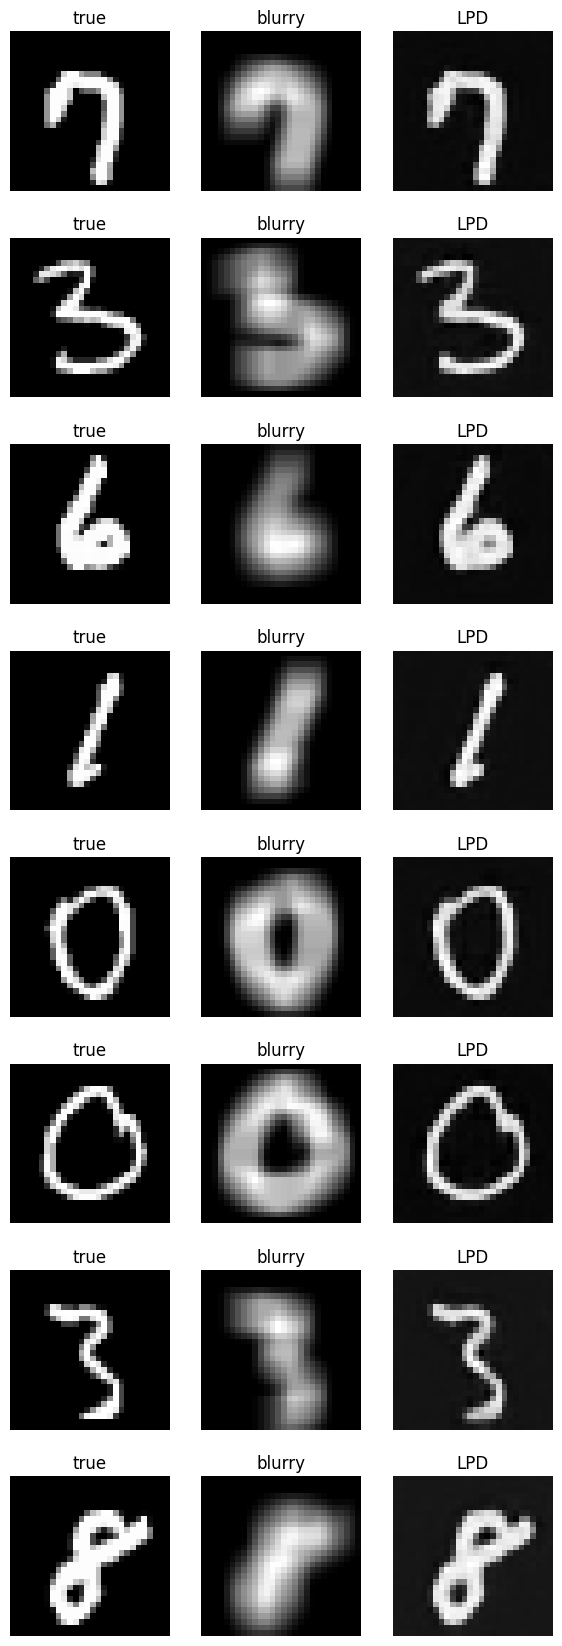

In [8]:
### see how it performs on test images
for batch_idx, (x_true, _) in enumerate(test_dataloader):
    x_true = x_true.to(device)
    y = fwd_op(x_true)
    x_init = torch.zeros_like(x_true).to(device)

    x_recon = lpd_net(y, x_init) # reconstruct using the trained network

    num_samples = 8  # Limit to a few samples for visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(7, 21))
    ### let's see the images
    for i in range(num_samples):
        # Plot true
        axes[i, 0].imshow((x_true[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 0].set_title('true')

        # Plot blurry
        axes[i, 1].imshow((y[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 1].set_title('blurry')

        # Plot ground truth image
        axes[i, 2].imshow((x_recon[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 2].set_title('LPD')

        # Remove axis ticks
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')

    plt.show()
    break

In [9]:
#see how it performs when we run more iterations than we trained
lpd_net.load_state_dict(torch.load(modelpath, weights_only=True))
cnn_image_layers_pretrained = prox_net_primal().to(device)
cnn_image_layers_pretrained = lpd_net.cnn_image_layers
cnn_data_layers_pretrained = prox_net_dual().to(device)
cnn_data_layers_pretrained = lpd_net.cnn_data_layers

### use the trained model for reconstruction with different number of iterations
def recon_op(y, x_init, num_iter):
  x = x_init
  h = torch.zeros_like(y)
  for iteration in range(num_iter):
      h = cnn_data_layers_pretrained(h, y, lpd_net.sigma * fwd_op(x))
      x = cnn_image_layers_pretrained(x, lpd_net.tau * adj_op(h))
  return x

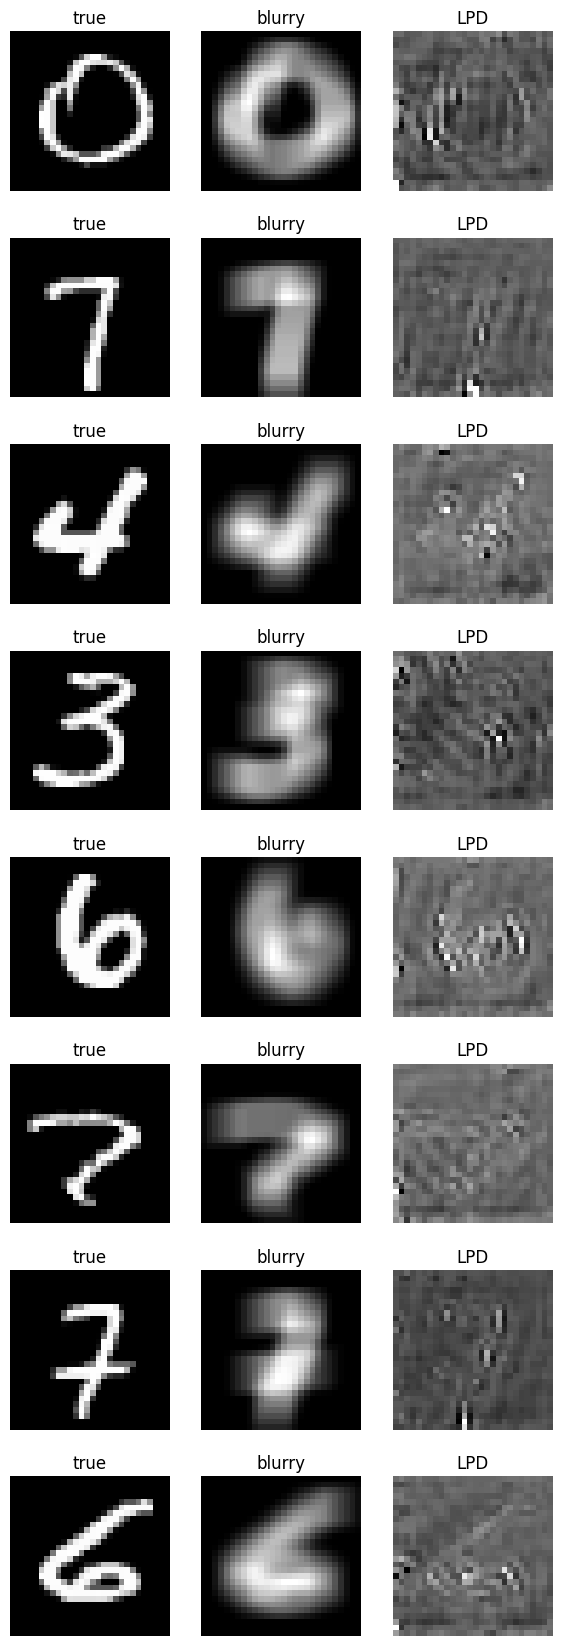

In [10]:
### see how it performs on test images
for batch_idx, (x_true, _) in enumerate(test_dataloader):
    x_true = x_true.to(device)
    y = fwd_op(x_true)
    x_init = torch.zeros_like(x_true).to(device)

    x_recon = recon_op(y, x_init, 8) # reconstruct using the trained network by running 8 iterations whereas the model was trained for 5 iterations

    num_samples = 8  # Limit to a few samples for visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(7, 21))
    ### let's see the images
    for i in range(num_samples):
        # Plot true
        axes[i, 0].imshow((x_true[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 0].set_title('true')

        # Plot blurry
        axes[i, 1].imshow((y[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 1].set_title('blurry')

        # Plot ground truth image
        axes[i, 2].imshow((x_recon[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 2].set_title('LPD')

        # Remove axis ticks
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')

    plt.show()
    break